# Dynap-SE2 DC Excitation


## Imports

In [1]:
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train
from rockpool.timeseries import TSEvent, TSContinuous

# Utils
from typing import Optional, Tuple, Any
from rockpool.nn.modules.module import ModuleBase
import numpy as np
from tqdm import tqdm
import time

# - Plotting and config
import matplotlib.pyplot as plt


# - Jax imports
import jax
from jax.experimental.optimizers import adam
from rockpool.training import jax_loss as jl
from itertools import count

# Dynap-SE2 imports
from rockpool.devices.dynapse.mapper import mapper
from rockpool.devices.dynapse.quantize.autoencoder import autoencoder_quantization
from rockpool.devices.dynapse.interface.config import config_from_specification
from rockpool.devices.dynapse.config.parameter import parameter_clustering
from rockpool.devices.dynapse.interface.utils import find_dynapse_boards
from rockpool.devices.dynapse.interface.samna import DynapseSamna


# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
 [py.warnings]


## Step 0 : No input, just DC

Just prove that the interfacing works


## Step 1 : Build a Network


In [2]:
# set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_GAIN_N", 3, 40)
# set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_LEAK_N", 0, 255)
# set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_REFR_N", 3, 255)
# set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_DC_P", 2, 80)
# set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_SPKTHR_P", 3, 255)
net = Sequential(DynapSim(10, has_rec=False, Iscale=1e-7, Idc=4e-8, Ispkthr=2e-7))

## Step 2 : Simulate


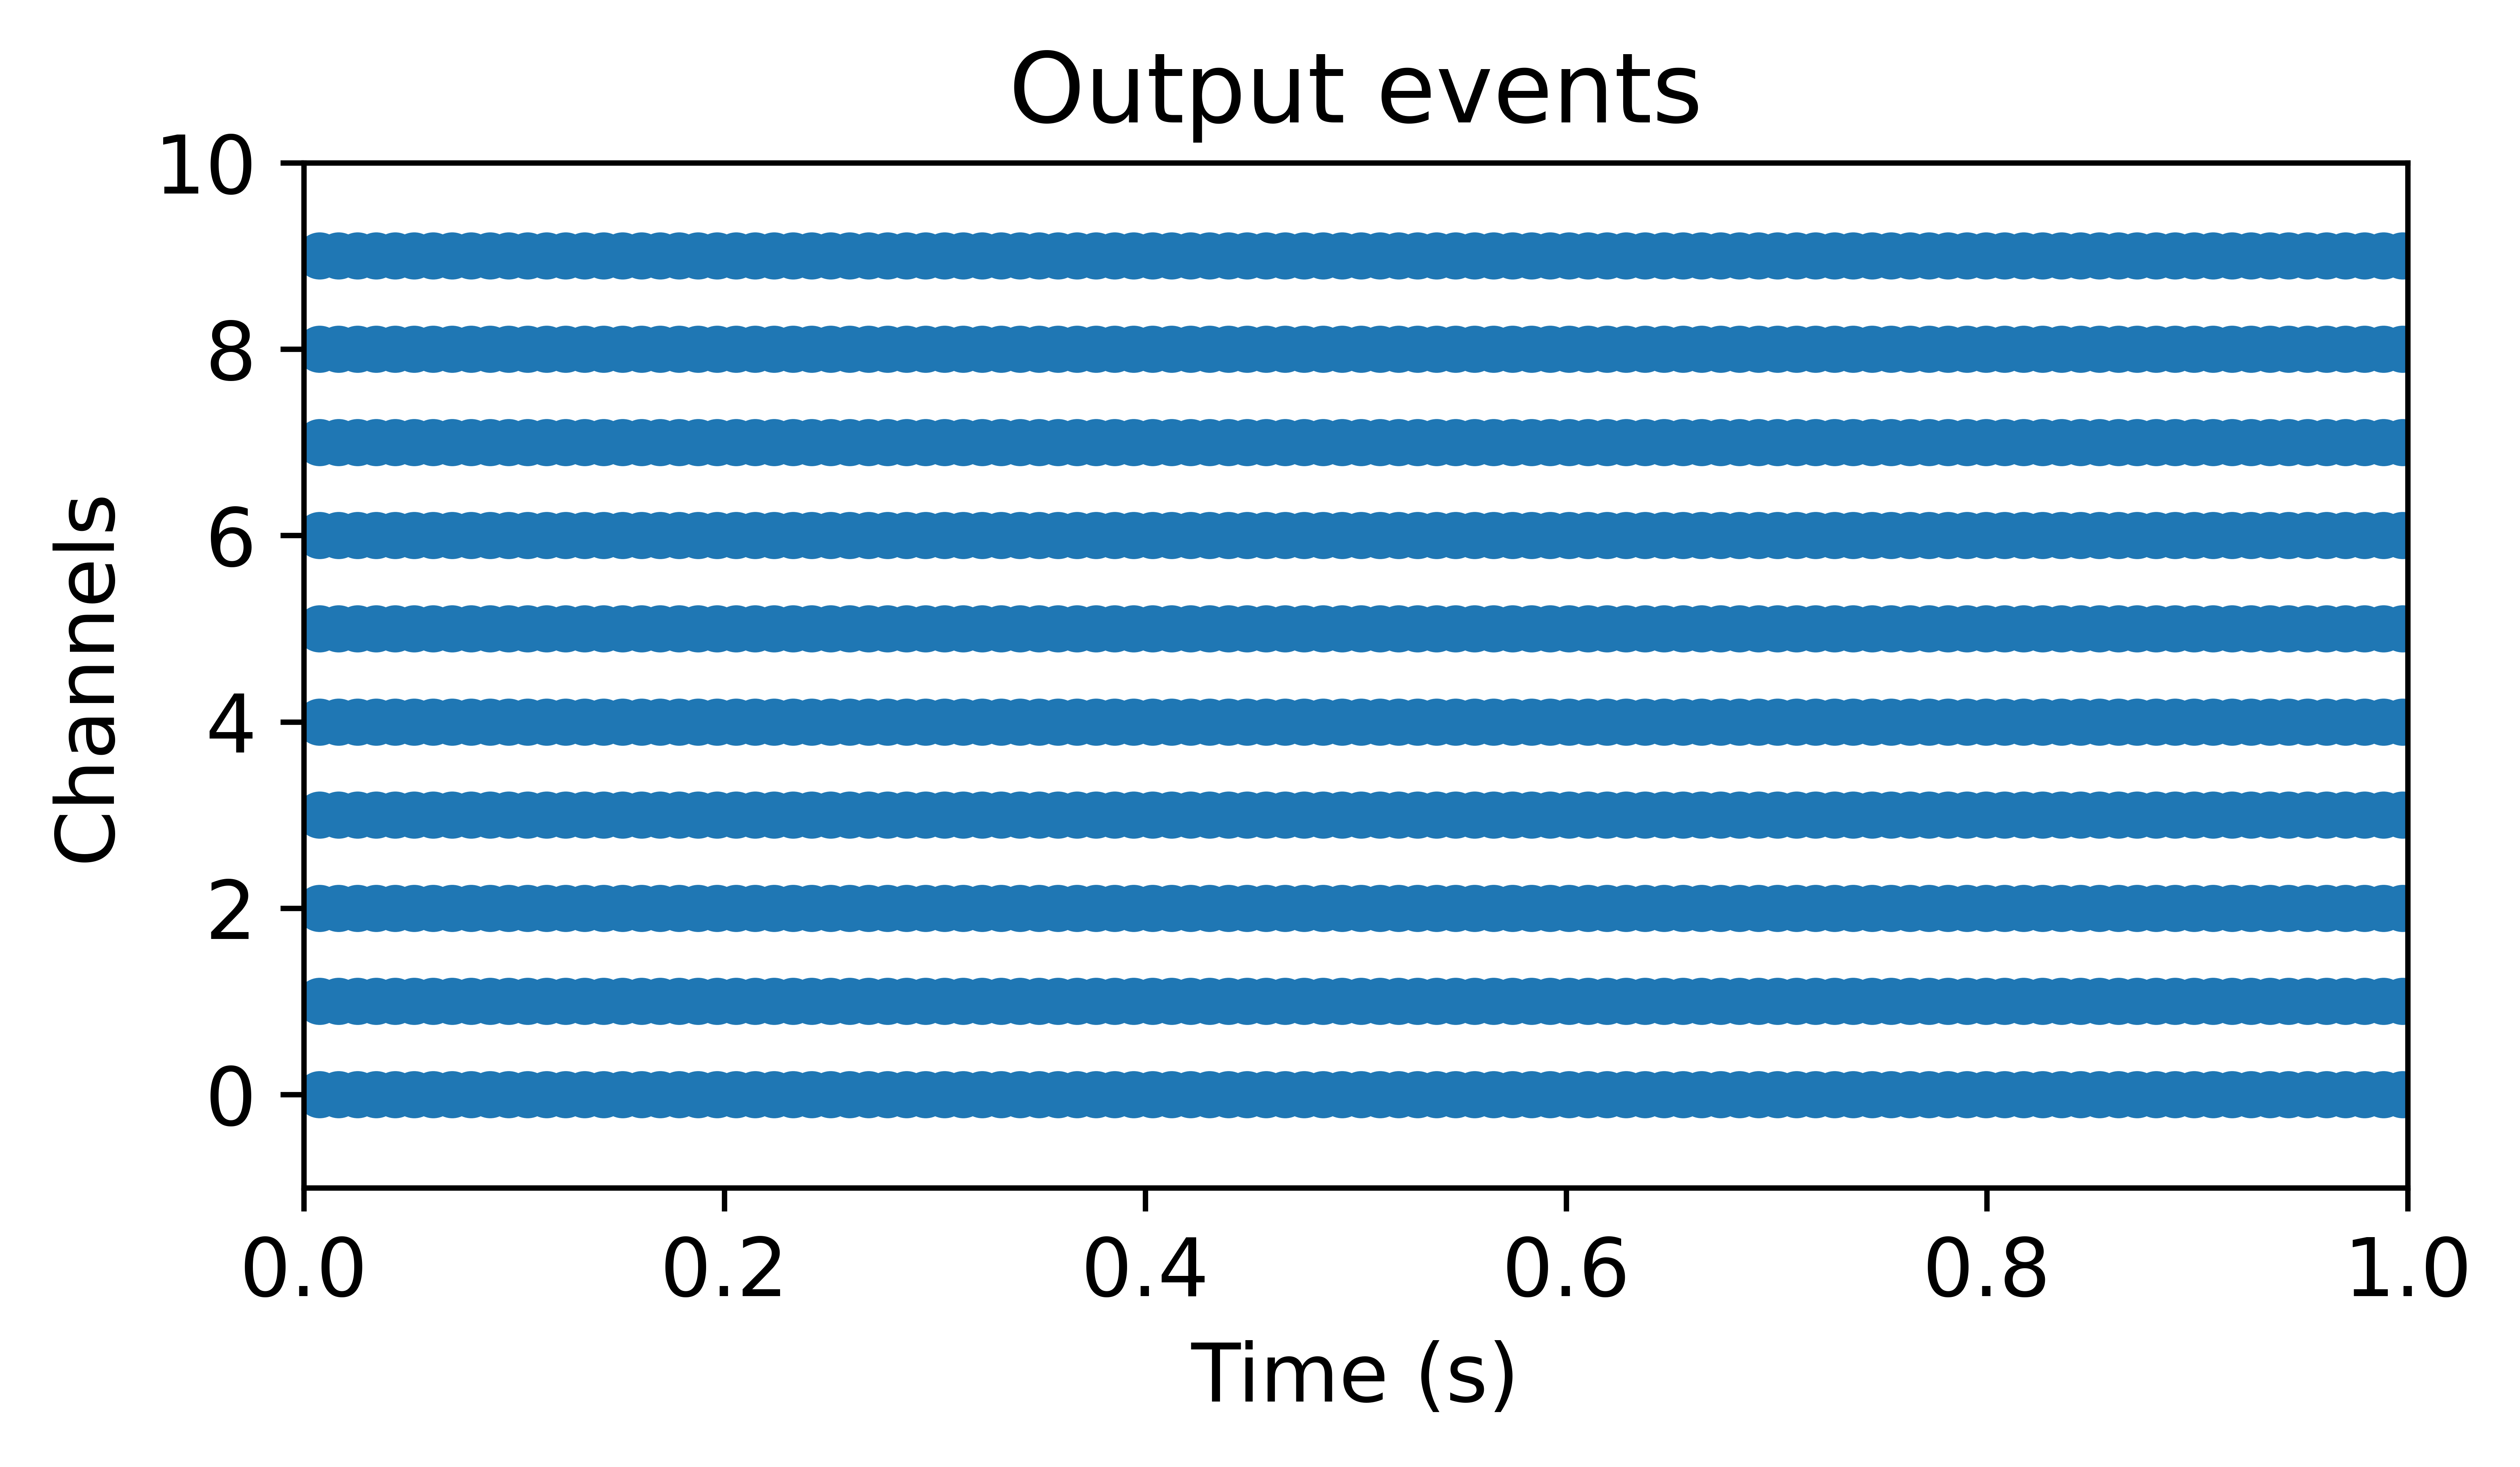

In [3]:
net.reset_state()
dt = 1e-3
out, state, rec = net(np.zeros(1000))
TSEvent.from_raster(out[0], dt, name = 'Output events').plot();

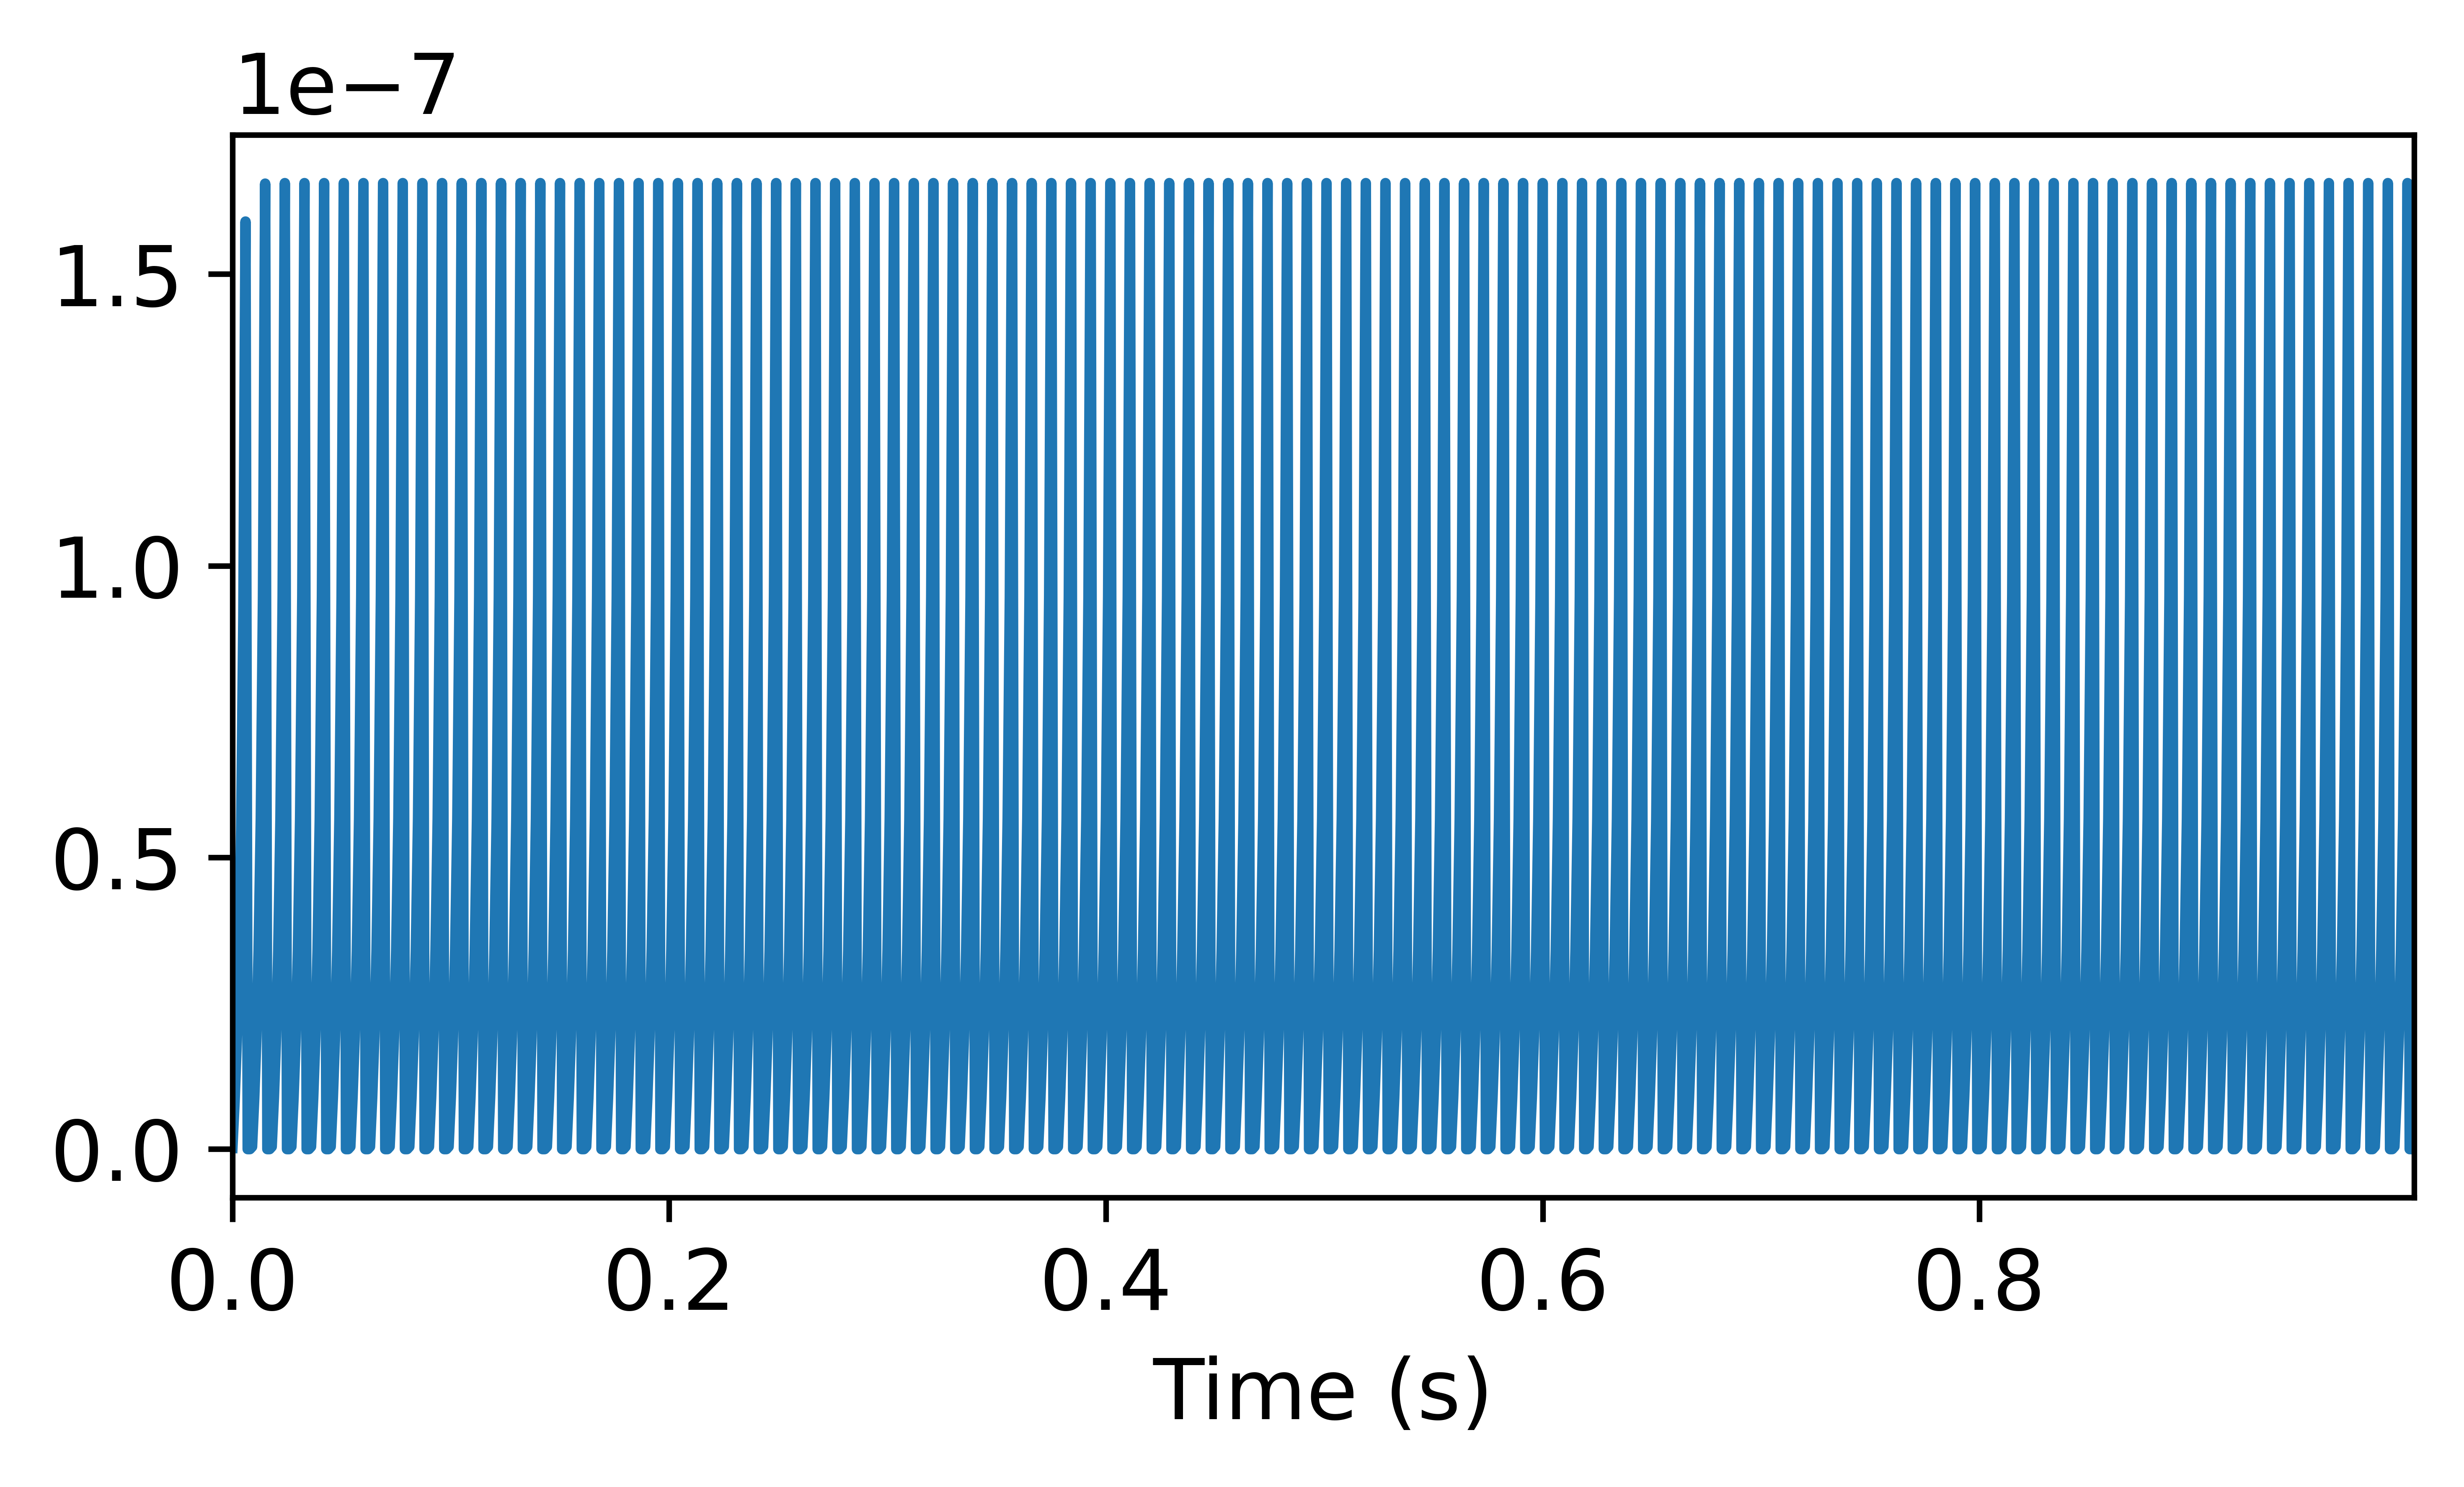

In [4]:
TSContinuous.from_clocked(rec['0_DynapSim']['imem'][0,:,0], dt=dt).plot()

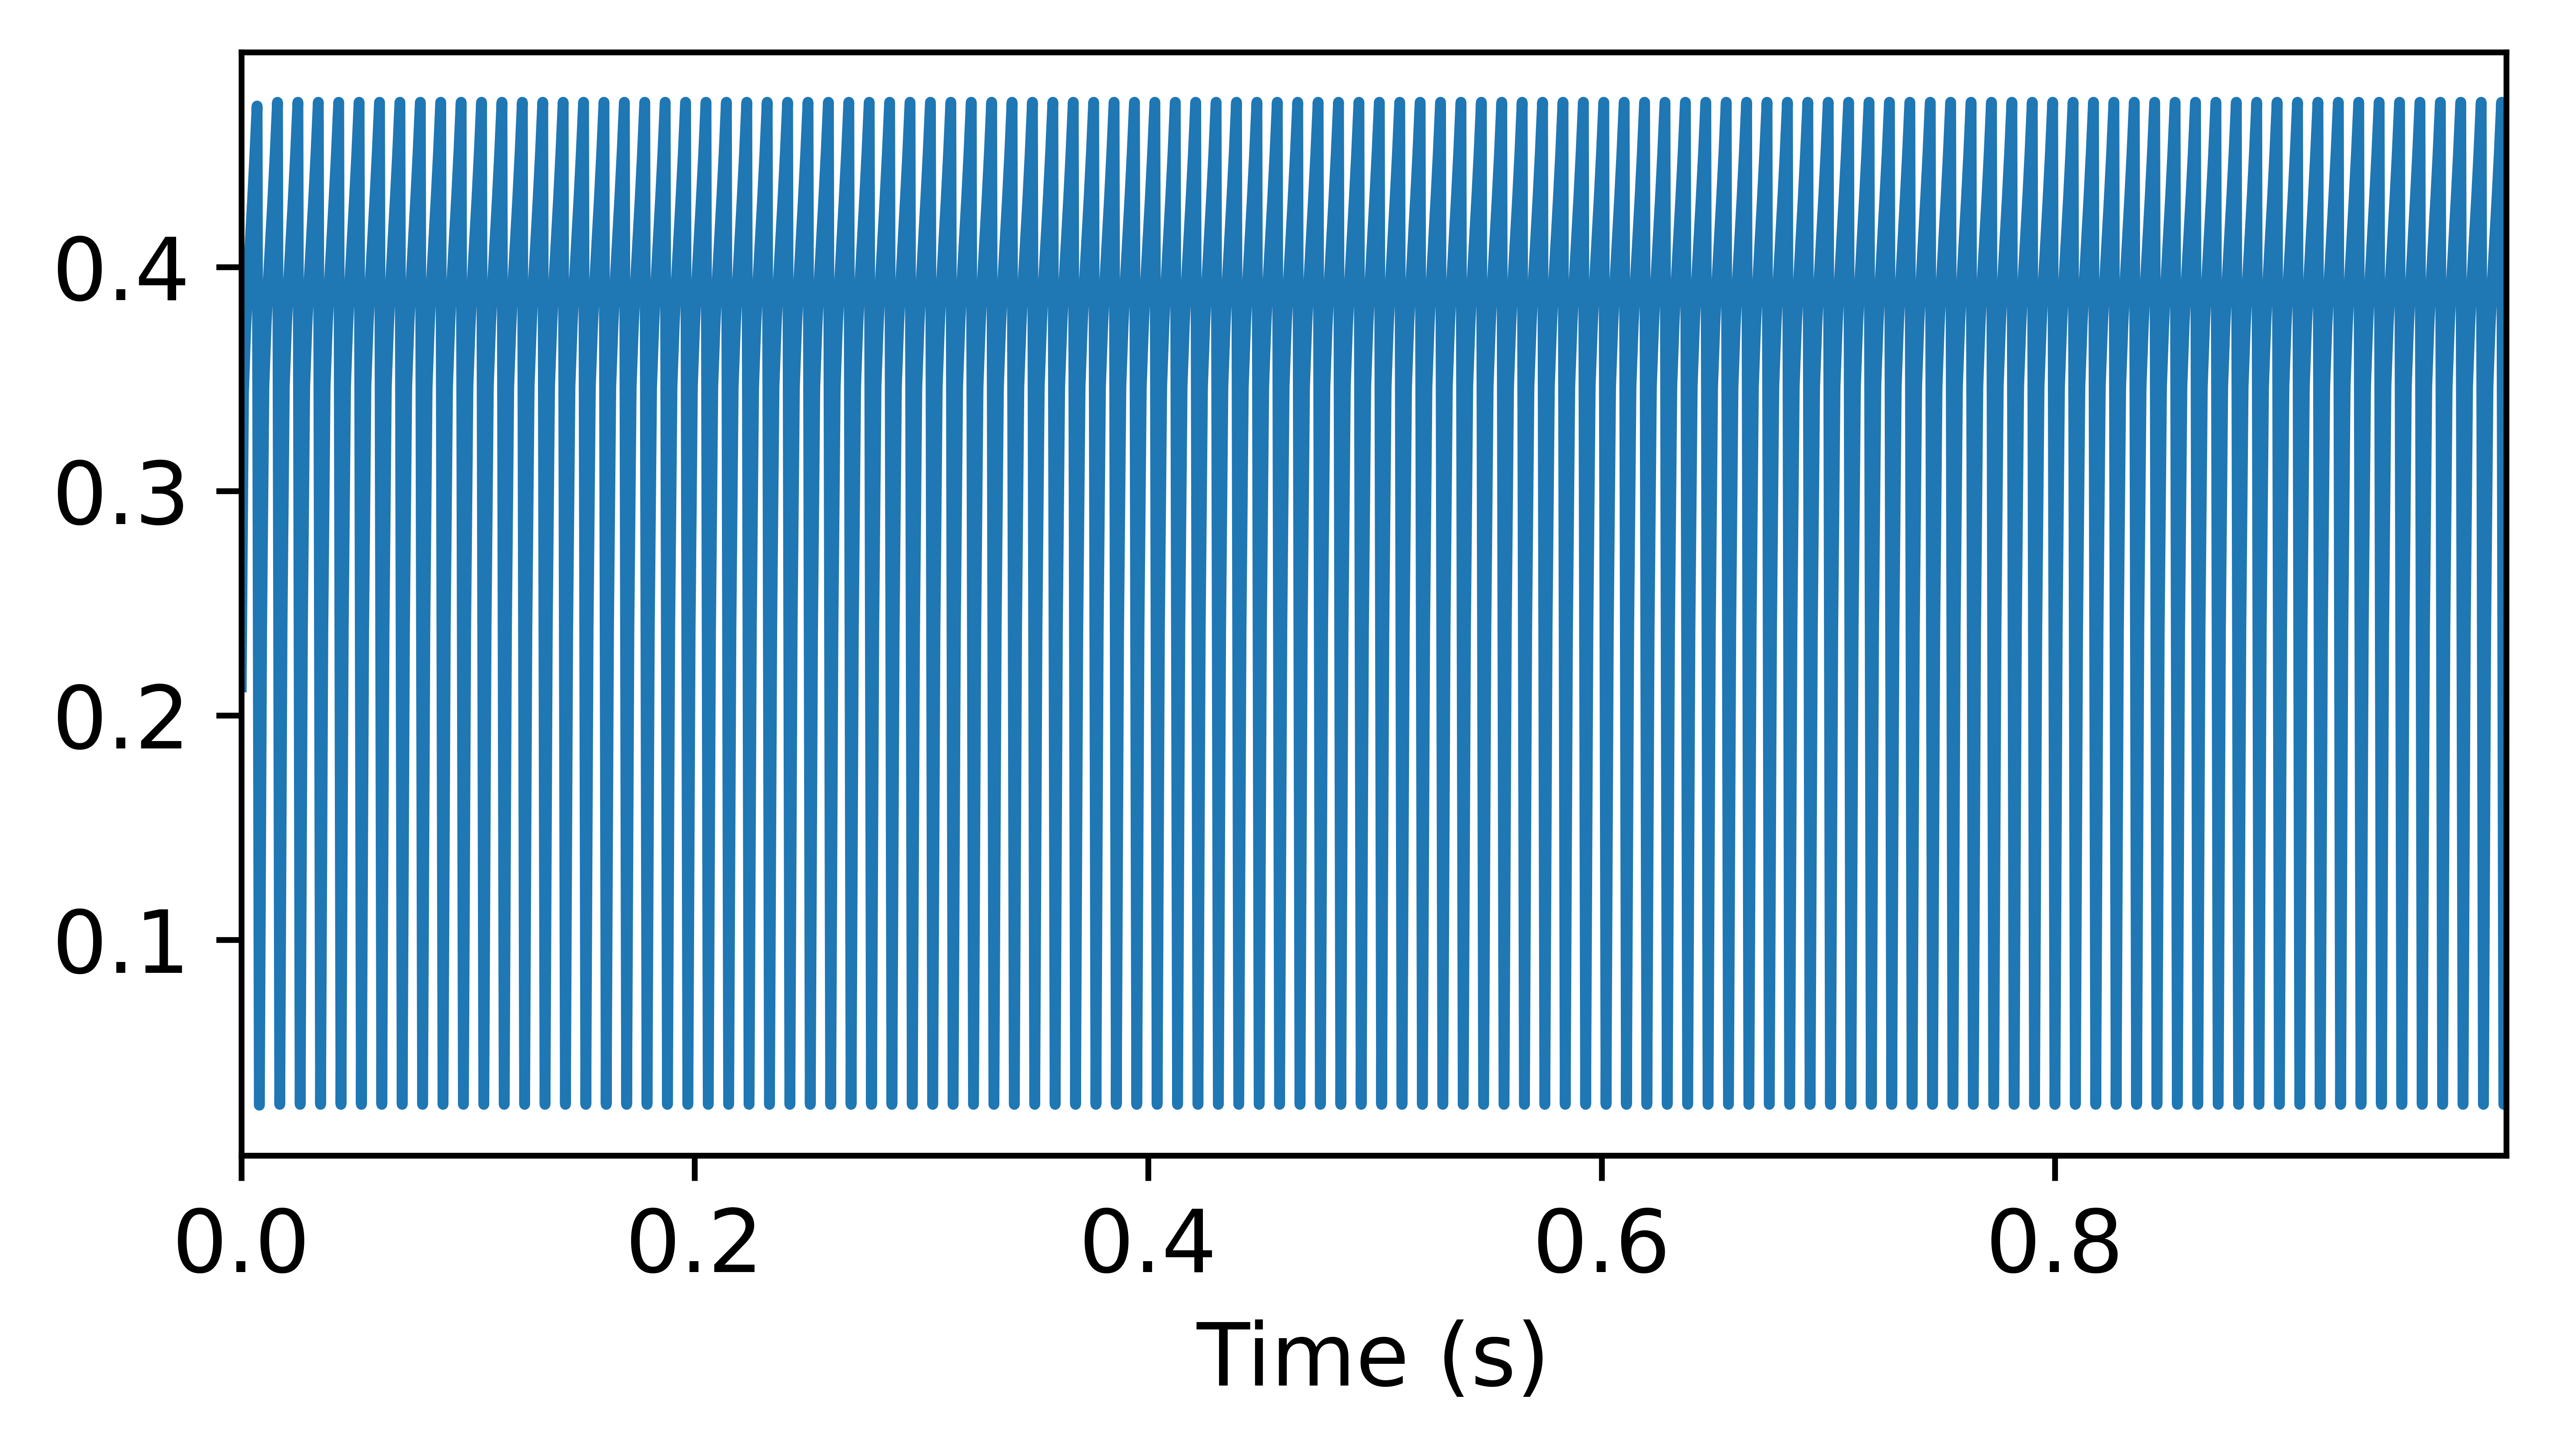

In [5]:
TSContinuous.from_clocked(rec['0_DynapSim']['vmem'][0,:,0], dt=dt).plot()

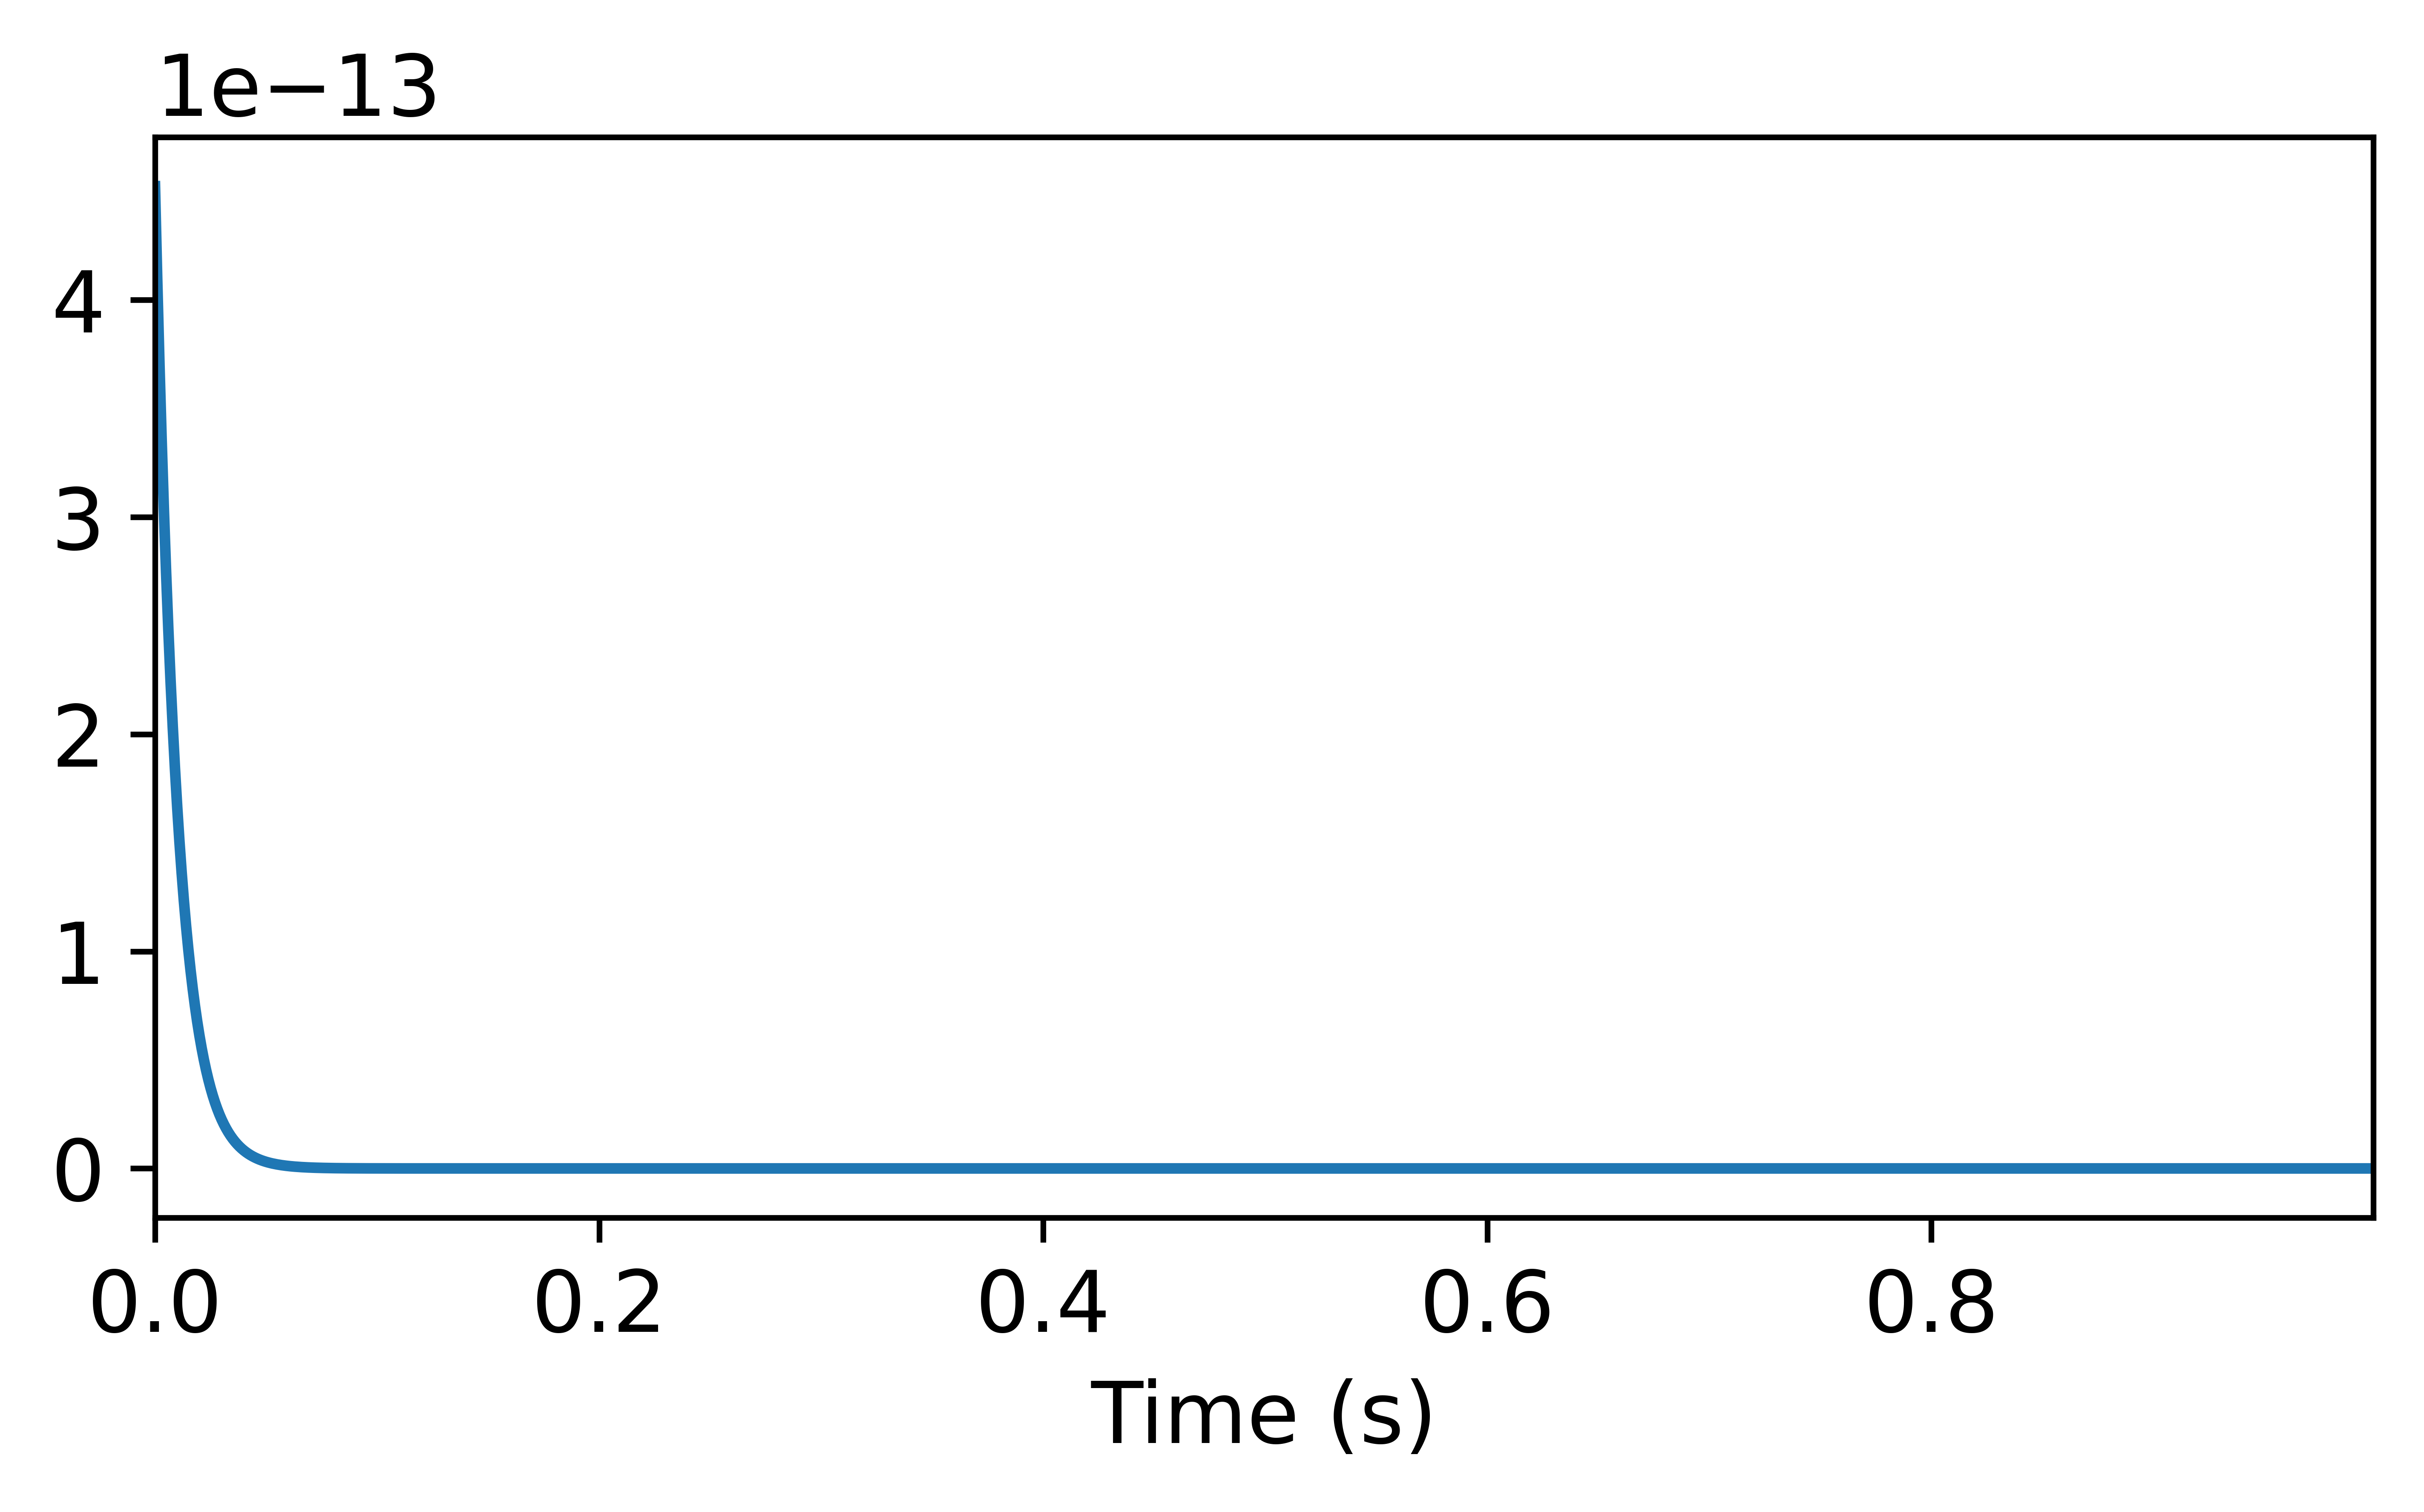

In [6]:
TSContinuous.from_clocked(rec['0_DynapSim']['isyn'][0,:,0], dt=dt).plot()

## Step 4 : Extract the Computational Graph

In [7]:
net.as_graph()

GraphHolder "JaxSequential__4671744864" with 10 input nodes -> 10 output nodes

## Step 5 : Map the Network to a Hardware Specification

In [8]:
spec = mapper(net.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__4671744864" with 10 input nodes -> 10 output nodes,
 'weights_in': None,
 'weights_rec': None,
 'Iscale': 1e-07,
 'Igain_mem': [2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11,
  2.1276595069119608e-11],
 'Igain_syn': [8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09,
  8.687943697793798e-09],
 'Igain_ahp': [2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11,
  2.8368795160216287e-11],
 'Itau_ahp': [2.83687951602162

In [9]:
spec.update(parameter_clustering(**spec, n_clusters=1))
spec

{'mapped_graph': GraphHolder "JaxSequential__4671744864" with 10 input nodes -> 10 output nodes,
 'weights_in': None,
 'weights_rec': None,
 'Iscale': [1e-07],
 'Igain_mem': [2.1276595069119608e-11],
 'Igain_syn': [8.687943697793798e-09],
 'Igain_ahp': [2.8368795160216287e-11],
 'Itau_ahp': [2.8368795160216287e-11],
 'Itau_mem': [5.319148767279902e-12],
 'Ipulse_ahp': [0.3499999940395355],
 'Itau_syn': [8.687943420238042e-11],
 'Iw_ahp': [0.0],
 'If_nmda': [4.999999980020986e-13],
 'Ipulse': [3.4999999343199306e-08],
 'Ispkthr': [2.0000000233721948e-07],
 'Idc': [3.999999975690116e-08],
 'Iref': [1.049999975855087e-09],
 'n_cluster': 1,
 'core_map': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n_neuron': 10}

## Step 6 : Quantize Weights

In [10]:
spec.update(autoencoder_quantization(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__4671744864" with 10 input nodes -> 10 output nodes,
 'weights_in': [None],
 'weights_rec': [None],
 'Iscale': [1e-07],
 'Igain_mem': [2.1276595069119608e-11],
 'Igain_syn': [8.687943697793798e-09],
 'Igain_ahp': [2.8368795160216287e-11],
 'Itau_ahp': [2.8368795160216287e-11],
 'Itau_mem': [5.319148767279902e-12],
 'Ipulse_ahp': [0.3499999940395355],
 'Itau_syn': [8.687943420238042e-11],
 'Iw_ahp': [0.0],
 'If_nmda': [4.999999980020986e-13],
 'Ipulse': [3.4999999343199306e-08],
 'Ispkthr': [2.0000000233721948e-07],
 'Idc': [3.999999975690116e-08],
 'Iref': [1.049999975855087e-09],
 'n_cluster': 1,
 'core_map': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n_neuron': 10,
 'sign_in': [None],
 'sign_rec': [None],
 'Iw_0': [0.0],
 'Iw_1': [0.0],
 'Iw_2': [0.0],
 'Iw_3': [0.0],
 'quantization_loss': [None]}

## Step 7 : Quantize Parameters

In [11]:
spec.update(config_from_specification(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__4671744864" with 10 input nodes -> 10 output nodes,
 'weights_in': [None],
 'weights_rec': [None],
 'Iscale': [1e-07],
 'Igain_mem': [2.1276595069119608e-11],
 'Igain_syn': [8.687943697793798e-09],
 'Igain_ahp': [2.8368795160216287e-11],
 'Itau_ahp': [2.8368795160216287e-11],
 'Itau_mem': [5.319148767279902e-12],
 'Ipulse_ahp': [0.3499999940395355],
 'Itau_syn': [8.687943420238042e-11],
 'Iw_ahp': [0.0],
 'If_nmda': [4.999999980020986e-13],
 'Ipulse': [3.4999999343199306e-08],
 'Ispkthr': [2.0000000233721948e-07],
 'Idc': [3.999999975690116e-08],
 'Iref': [1.049999975855087e-09],
 'n_cluster': 1,
 'core_map': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n_neuron': 10,
 'sign_in': [None],
 'sign_rec': [None],
 'Iw_0': [0.0],
 'Iw_1': [0.0],
 'Iw_2': [0.0],
 'Iw_3': [0.0],
 'quantization_loss': [None],
 'config': <samna.dynapse2.Dynapse2Configuration at 0x29cecd0f0>,
 'input_channel_map': {},
 'biasgen': {'SOIF_DC_P': (4, 96),
  'DENM_NMREV_N': (0

In [12]:
from rockpool.devices.dynapse.config.simconfig import DynapSimCore
from rockpool.devices.dynapse.infrastructure.router import Router
core = DynapSimCore.from_Dynapse2Core(spec['config'].chips[0].cores[0])


In [13]:
core

DynapSimCore(Iw_0=8.201291515677665e-14, Iw_1=8.201291515677665e-14, Iw_2=8.201291515677665e-14, Iw_3=8.201291515677665e-14, C_ahp=4e-11, C_ampa=2.45e-11, C_gaba=2.5e-11, C_nmda=2.5e-11, C_pulse_ahp=5e-13, C_pulse=5e-13, C_ref=1.5e-12, C_shunt=2.45e-11, C_mem=3e-12, Io=5e-13, kappa_n=0.75, kappa_p=0.66, Ut=0.025, Vth=0.7, Idc=3.978978984522189e-08, If_nmda=5.182916465465277e-13, Igain_ahp=2.8452687958659455e-11, Igain_ampa=8.676111624807385e-09, Igain_gaba=8.676111624807385e-09, Igain_nmda=8.676111624807385e-09, Igain_shunt=8.676111624807385e-09, Igain_mem=2.124553968342711e-11, Ipulse_ahp=2.093838005524747e-06, Ipulse=3.466940299925298e-08, Iref=1.0405710613480151e-09, Ispkthr=1.9973800065792957e-07, Itau_ahp=2.8338877414392536e-11, Itau_ampa=8.67288151386193e-11, Itau_gaba=8.67288151386193e-11, Itau_nmda=8.67288151386193e-11, Itau_shunt=8.67288151386193e-11, Itau_mem=5.270256462009556e-12, Iw_ahp=4.54122204593148e-13)

In [14]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    se2 = DynapseSamna((0,255),se2_devices[0], spec['config'])
time.sleep(1)

In [15]:

plt.rcParams["figure.figsize"] = [5.6, 5.6]


def test_network(sample, sample_name):
    out, state, rec = se2(sample, spec['input_channel_map'])

    fig, axes = plt.subplots(2, 1)

    ticks = list(state["channel_map"].keys())
    labels = [dest.tag for dest in state["channel_map"].values()]

    plt.sca(axes[0])
    TSEvent.from_raster(
        sample, t_start=state["start_time"], t_stop=state["stop_time"]+dt, dt=dt
    ).plot()
    plt.title(sample_name)
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=state["start_time"], t_stop=state["stop_time"]+dt, dt=dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

In [110]:
se2.current_timestamp()

17.438017

Rate = 819.0


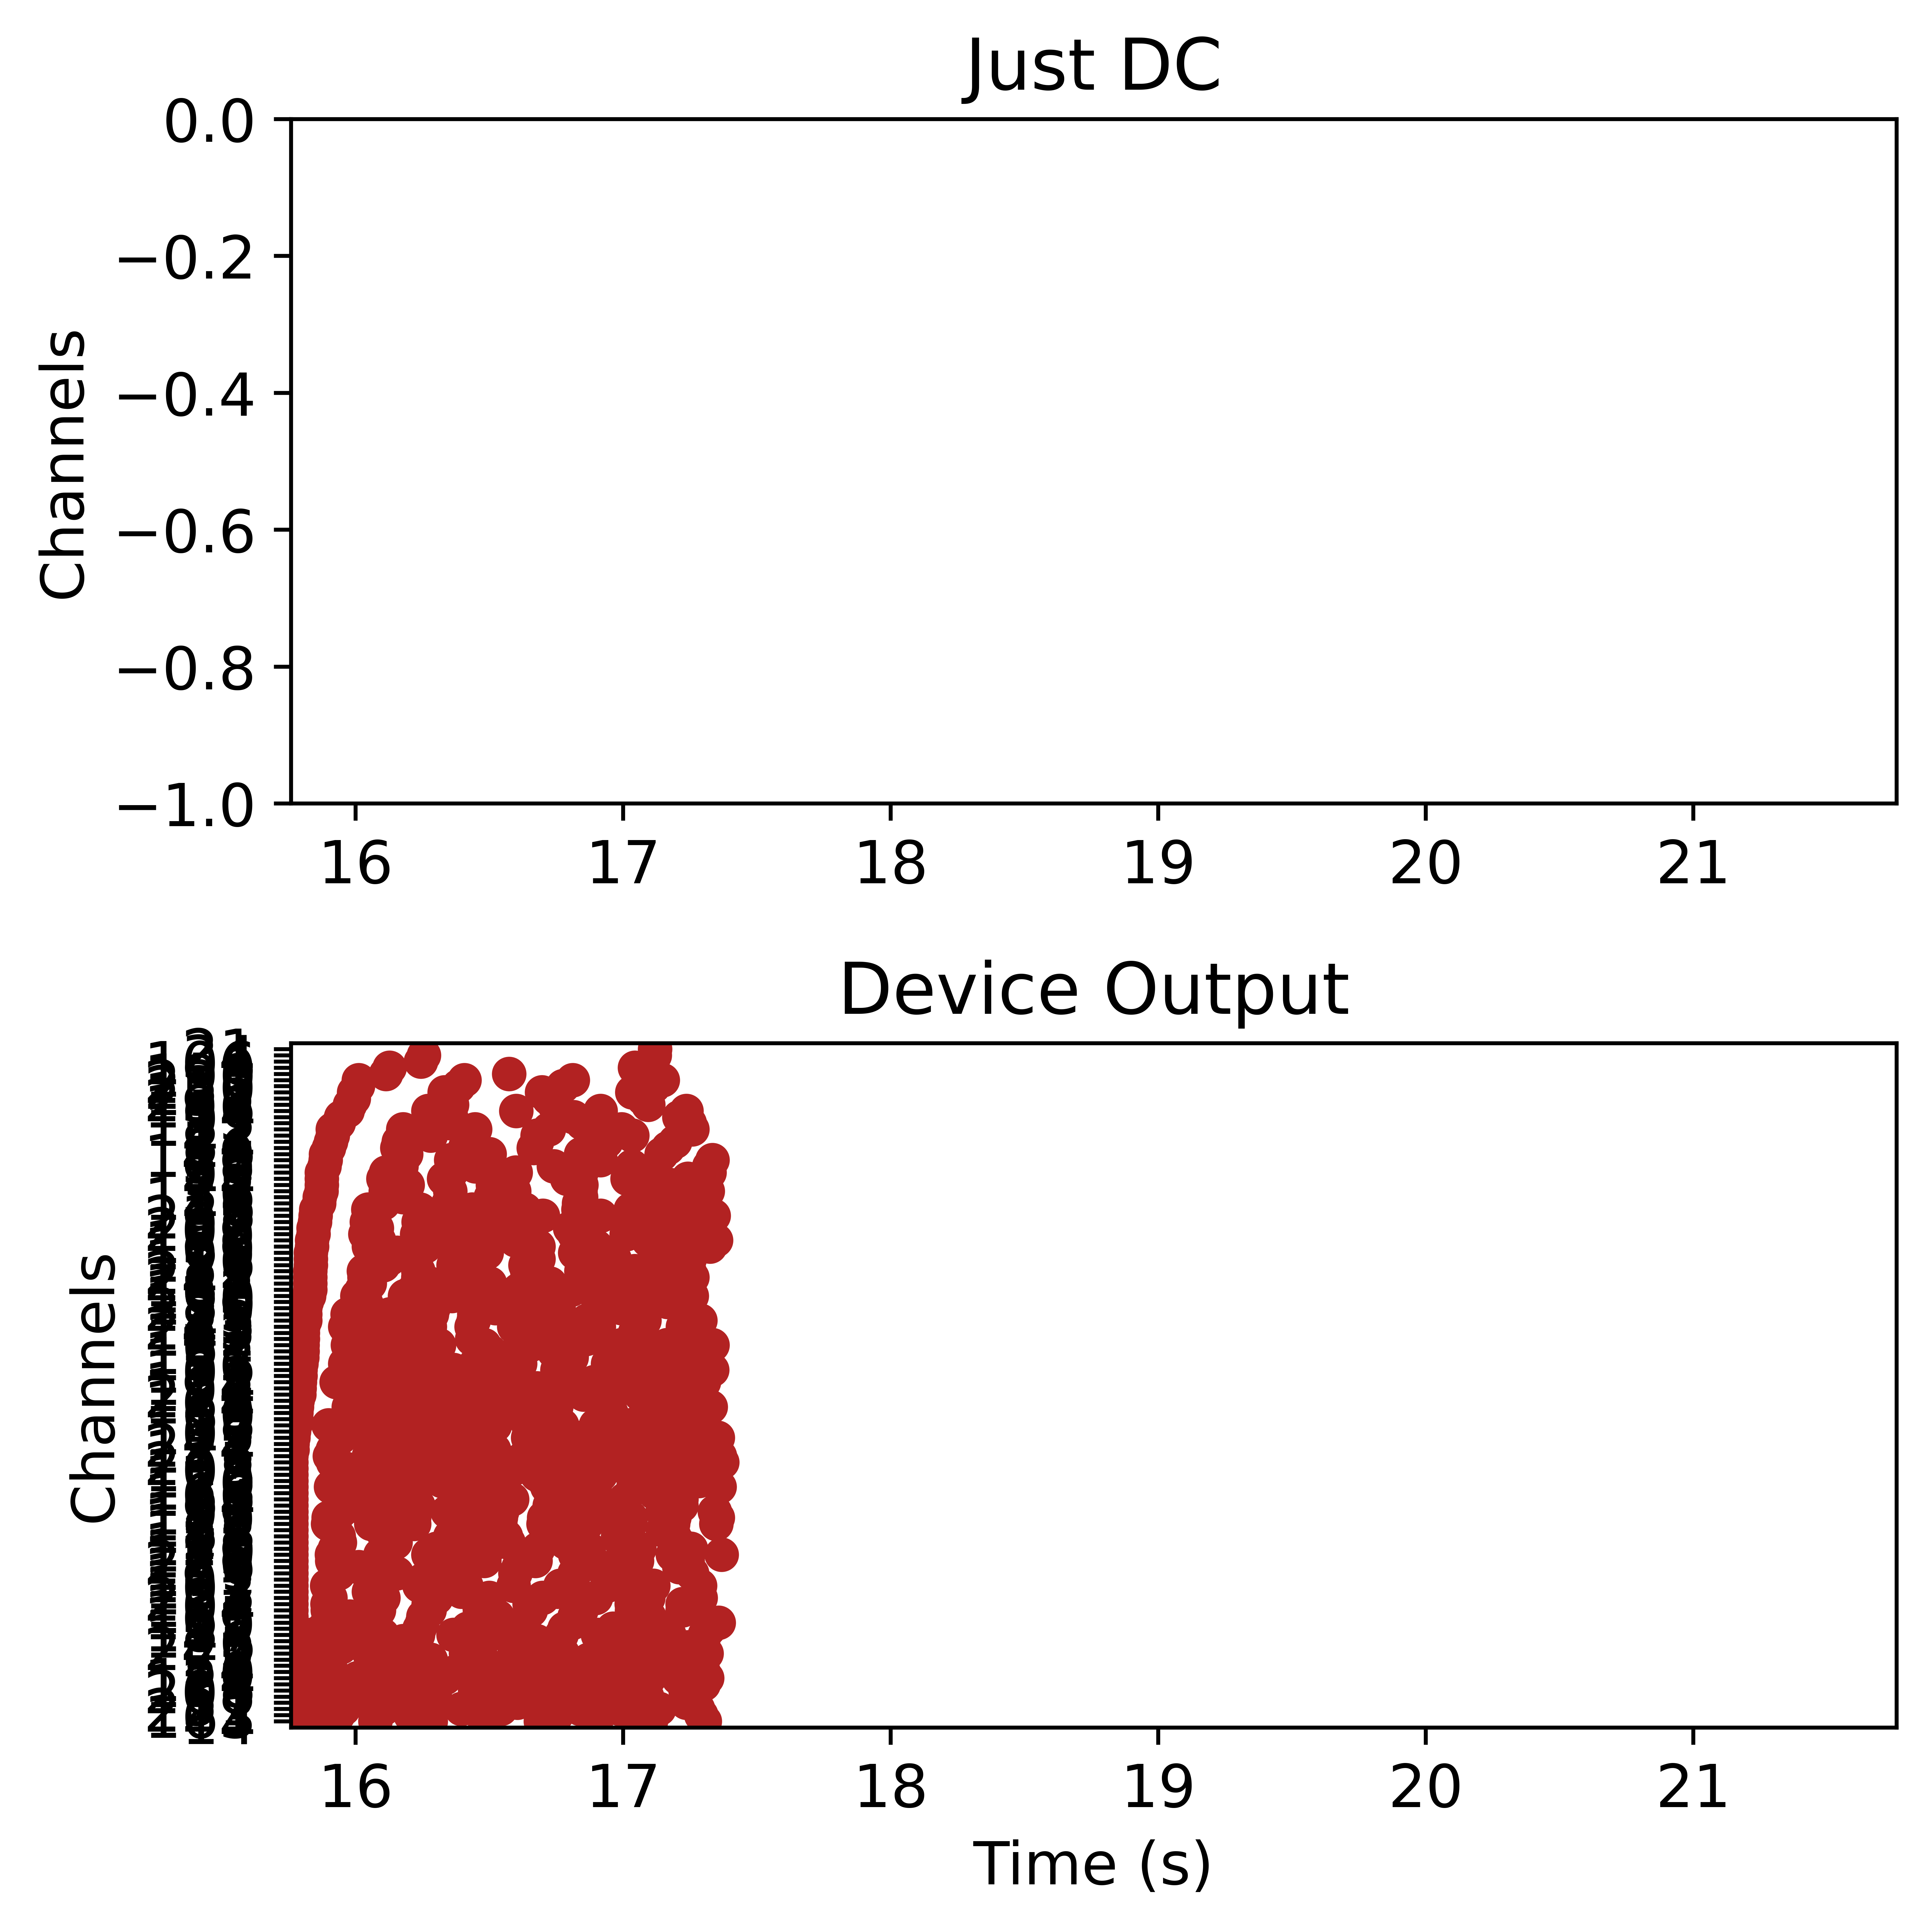

In [88]:
test_network(np.zeros((5000,0)), "Just DC")